In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# Initialize the SIFT detector and the FLANNBASED Matcher
detector = cv2.SIFT_create()
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

In [5]:
def read_image_and_compute_keypoints(object_imgs: list, scene_imgs: list, detector: cv2.SIFT):
        imgs_dict = {}

    
    # Load model images and compute SIFT detector to find keypoints/descriptors for each image
    for name_img in object_imgs:
        img_load = cv2.imread('models/' + name_img + '.jpg', cv2.IMREAD_GRAYSCALE)
        
        """
        # Drop center of images
        row = int(img_load.shape[0]/2)
        col = int(img_load.shape[1]/2)
        pour = 0.5
        new_color = 255 # White
        img_load[int(row - row*pour) : int(row + row*pour), int(col - col*pour): int(col + col*pour)] = new_color
        #
        """

        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

        
    # Load scene images and compute SIFT detector to find keypoints/descriptors for each image
    for name_img in scene_imgs:
        img_load = cv2.imread('scenes/' + name_img + '.png', cv2.IMREAD_GRAYSCALE)
        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    return imgs_dict

In [63]:
def matching_and_localize_objects_in_scene(object_imgs, imgs_dict, name_scene_img, ratio_test=0.6):
    """
    For each images, compute matching with the scene image, keep only the good matches based on Lowe's ratio.
    If there are enough good matches, the model image is found in the scene image.
    Return the spatial coordinates of the corners of model images found in the scene image
    """
    
    all_scene_corners = {}
    all_good ={}
    
    object_imgs = ['0', '1', '11', '19', '24', '25', '26']
 
    for name in object_imgs:
        object_des, object_kp = imgs_dict[name]['des'], imgs_dict[name]['kp']
        scene_des, scene_kp = imgs_dict[name_scene_img]['des'], imgs_dict[name_scene_img]['kp']
        
        #-- matching
        matches = matcher.knnMatch(object_des, scene_des, k=2)
    
        #-- store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < ratio_test*n.distance:
                good.append(m)
                
        if len(good) > 60:        
            #-- Get the keypoints from the good matches
            object_good_kp = np.float32([ object_kp[m.queryIdx].pt for m in good ])
            scene_good_kp = np.float32([ scene_kp[m.trainIdx].pt for m in good ])   


            #-- Get the corners of object
            h,w = imgs_dict[name]['shape'][0:2]
            object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            #-- Get the homography of object/scene
            H, _ =  cv2.findHomography(object_good_kp, scene_good_kp, cv2.RANSAC, 5.0)

            #-- Get the corners of object in scene
            scene_corners = cv2.perspectiveTransform(object_corners, H)


            all_scene_corners[name] = scene_corners
            all_good[name] = good
        
    return all_scene_corners, all_good

In [64]:
def check_best_color_matches(all_scene_corners, name_scene_img):
    """
    This method checks between the model images found in the scene image whether the average of 
    the colours in the corners matches the colours in the model image
    """
    
    scene_img_bgr = cv2.imread('scenes/' + name_scene_img + '.png')
    best_all_scene_corners = {}
    
    for name in all_scene_corners.keys():

        x_min = max(int(np.min(all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(all_scene_corners[name], axis=0)[0][1])
        
        object_img_bgr = cv2.imread('models/' + name + '.jpg')
        
        object_img_mean_color = object_img_bgr.mean(axis=0).mean(axis=0)
        object_in_scene_img = scene_img_bgr[y_min:y_max,x_min:x_max]
        object_in_scene_img_mean_color = object_in_scene_img.mean(axis=0).mean(axis=0)   
        color_diff = np.sqrt(np.sum([value ** 2 for value in abs(object_img_mean_color - 
                                                                 object_in_scene_img_mean_color)]))
        
        #color_diff = (np.sum([value **2 for value in (object_img_mean_color - object_in_scene_img_mean_color)]))/4
        
        if color_diff < 50:
            best_all_scene_corners[name] = all_scene_corners[name]
        
    return best_all_scene_corners

In [65]:
def drawn_object_lines_in_scene(img_scene, best_all_scene_corners):
    """
    This method draws on the scene the rectangles corresponding to the packages 
    found from the model images
    """
    for name in best_all_scene_corners.keys():
        scene_corners = best_all_scene_corners[name]
        img_scene = cv2.polylines(img_scene, [np.int32(scene_corners)], 
                                  isClosed=True, color=(0,255,0), thickness=5)
    return img_scene

In [66]:
def print_object_found(best_all_scene_corners):
    """
    This method create and print the informations for a scene image
    """
    for name in best_all_scene_corners.keys():  
        x_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(best_all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(best_all_scene_corners[name], axis=0)[0][1])
        
        print('Product {} - {} instance/s found:'.format(name, 1))
        print('\tInstance {} position: {}, width: {}px, height: {}px'.format(1, (x_min, y_min), (x_max-x_min), (y_max-y_min)))
    
    print('_' * 80 + '\n')

In [67]:
def stepA():
    """
    This method call all the functions and compute the step A
    """
    # model and scene images for step A
    object_imgs = ['0', '1', '11', '19', '24', '25', '26']
    scene_imgs = ['e1', 'e2', 'e3', 'e4', 'e5']
    
    # Initialize the SIFT detector and the FLANNBASED Matcher
    detector = cv2.SIFT_create()
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

    imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)
    
    for scene_name in scene_imgs:
        
        all_scene_corners, all_good= matching_and_localize_objects_in_scene(object_imgs, imgs_dict, scene_name)
        
        best_all_scene_corners = check_best_color_matches(all_scene_corners , scene_name)
        
        
        img_scene_rgb = cv2.cvtColor(cv2.imread('scenes/' + scene_name + '.png'), cv2.COLOR_BGR2RGB)
        img_scene_rgb = drawn_object_lines_in_scene(img_scene_rgb, best_all_scene_corners)

        
        print('Scene {} :'.format(scene_name))
        plt.imshow(img_scene_rgb)
        plt.show()
        print_object_found(best_all_scene_corners)

Scene e1 :


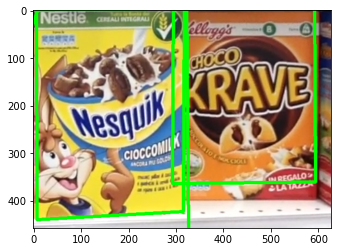

Product 0 - 1 instance/s found:
	Instance 1 position: (7, 0), width: 311px, height: 440px
Product 11 - 1 instance/s found:
	Instance 1 position: (293, 0), width: 301px, height: 364px
Product 26 - 1 instance/s found:
	Instance 1 position: (0, 0), width: 330px, height: 864px
________________________________________________________________________________

Scene e2 :


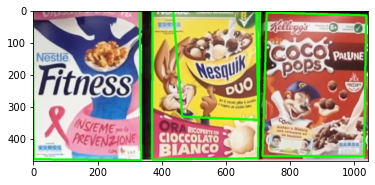

Product 0 - 1 instance/s found:
	Instance 1 position: (436, 0), width: 266px, height: 340px
Product 24 - 1 instance/s found:
	Instance 1 position: (0, 0), width: 337px, height: 465px
Product 25 - 1 instance/s found:
	Instance 1 position: (715, 7), width: 323px, height: 446px
Product 26 - 1 instance/s found:
	Instance 1 position: (371, 0), width: 337px, height: 463px
________________________________________________________________________________

Scene e3 :


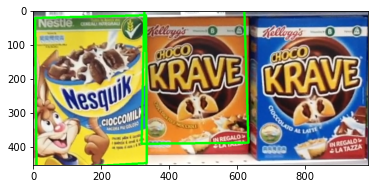

Product 0 - 1 instance/s found:
	Instance 1 position: (6, 12), width: 328px, height: 453px
Product 11 - 1 instance/s found:
	Instance 1 position: (319, 0), width: 314px, height: 390px
________________________________________________________________________________

Scene e4 :


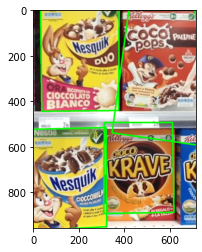

Product 0 - 1 instance/s found:
	Instance 1 position: (0, 515), width: 322px, height: 452px
Product 11 - 1 instance/s found:
	Instance 1 position: (310, 493), width: 307px, height: 399px
Product 25 - 1 instance/s found:
	Instance 1 position: (346, 0), width: 424px, height: 599px
Product 26 - 1 instance/s found:
	Instance 1 position: (32, 0), width: 345px, height: 444px
________________________________________________________________________________

Scene e5 :


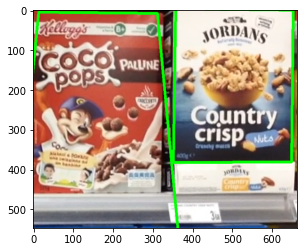

Product 19 - 1 instance/s found:
	Instance 1 position: (352, 0), width: 301px, height: 382px
Product 25 - 1 instance/s found:
	Instance 1 position: (0, 5), width: 365px, height: 560px
________________________________________________________________________________



In [68]:
stepA()

_____
TEST

In [379]:
detector = cv2.SIFT_create()
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

In [380]:
imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)

In [381]:
all_scene_corners, all_good= matching_and_localize_objects_in_scene(imgs_dict, 'e1')

In [371]:
all_scene_corners

{'0': array([[[437.49048 ,   6.068001]],
 
        [[470.18115 , 323.73416 ]],
 
        [[705.4536  , 340.91922 ]],
 
        [[696.65643 , -13.781502]]], dtype=float32),
 '24': array([[[ -2.583261 , -28.080864 ]],
 
        [[  2.6329534, 462.35687  ]],
 
        [[337.46738  , 466.04764  ]],
 
        [[332.35626  , -22.19086  ]]], dtype=float32),
 '25': array([[[ 728.73425  ,    7.4063563]],
 
        [[ 714.58966  ,  456.21432  ]],
 
        [[1031.4397   ,  453.10025  ]],
 
        [[1037.8706   ,   16.187939 ]]], dtype=float32),
 '26': array([[[372.05884 , -26.581305]],
 
        [[371.7851  , 463.4429  ]],
 
        [[701.6071  , 459.9292  ]],
 
        [[708.8668  , -23.56088 ]]], dtype=float32)}

In [373]:
best_all_scene_corners = check_best_color_matches(all_scene_corners , 'e2')
best_all_scene_corners

{'0': array([[[437.49048 ,   6.068001]],
 
        [[470.18115 , 323.73416 ]],
 
        [[705.4536  , 340.91922 ]],
 
        [[696.65643 , -13.781502]]], dtype=float32),
 '24': array([[[ -2.583261 , -28.080864 ]],
 
        [[  2.6329534, 462.35687  ]],
 
        [[337.46738  , 466.04764  ]],
 
        [[332.35626  , -22.19086  ]]], dtype=float32),
 '25': array([[[ 728.73425  ,    7.4063563]],
 
        [[ 714.58966  ,  456.21432  ]],
 
        [[1031.4397   ,  453.10025  ]],
 
        [[1037.8706   ,   16.187939 ]]], dtype=float32),
 '26': array([[[372.05884 , -26.581305]],
 
        [[371.7851  , 463.4429  ]],
 
        [[701.6071  , 459.9292  ]],
 
        [[708.8668  , -23.56088 ]]], dtype=float32)}

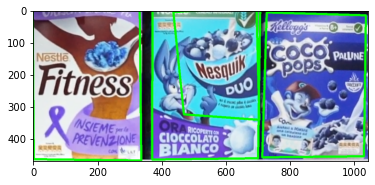

In [374]:
img_scene = cv2.imread('scenes/e2.png')
img_scene = drawn_object_lines_in_scene(img_scene, best_all_scene_corners)

plt.imshow(img_scene)
plt.show()

In [375]:
print_object_found(all_scene_corners)

Product 0 - 1 instance/s found:
	Instance 1 position: (437, 0), width: 268px, height: 340px
Product 24 - 1 instance/s found:
	Instance 1 position: (0, 0), width: 337px, height: 466px
Product 25 - 1 instance/s found:
	Instance 1 position: (714, 7), width: 323px, height: 449px
Product 26 - 1 instance/s found:
	Instance 1 position: (371, 0), width: 337px, height: 463px
________________________________________________________________________________



14.532868762588762


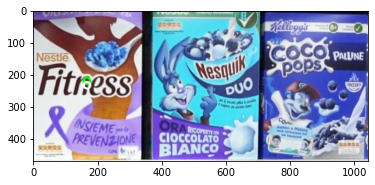

In [377]:
#-- color test

scene_img_bgr = cv2.imread('scenes/e2.png')  
scene_corners = all_scene_corners['24']

object_img_bgr = cv2.imread('models/24.jpg')


x_min = max(int(np.min(scene_corners, axis=0)[0][0]), 0)
y_min = max(int(np.min(scene_corners, axis=0)[0][1]), 0)
x_max = min(int(np.max(scene_corners, axis=0)[0][0]), scene_img_bgr.shape[1])
y_max = min(int(np.max(scene_corners, axis=0)[0][1]), scene_img_bgr.shape[0])


object_img_mean_color = object_img_bgr.mean(axis=0).mean(axis=0)
object_in_scene_img = scene_img_bgr[y_min:y_max,x_min:x_max]
object_in_scene_img_mean_color = object_in_scene_img.mean(axis=0).mean(axis=0)  

#color_diff = (np.sum([value **2 for value in (object_img_mean_color - object_in_scene_img_mean_color)]))/4
color_diff = np.sqrt(np.sum([value ** 2 for value in abs(object_img_mean_color - object_in_scene_img_mean_color)]))



center_real = tuple((scene_corners[0, 0, i] + scene_corners[1, 0, i] + scene_corners[2, 0, i] 
                + scene_corners[3, 0, i]) / 4 for i in (0, 1))

center_img = ((x_max + x_min)/2, (y_max + y_min)/2)

center_diff = ((center_real[0] - center_img[0])**2 + (center_real[1] - center_img[1])**2)/4



cv2.circle(scene_img_bgr , (int(center_real[0]),int(center_real[1])), 10 ,[0, 255, 0], 5)
cv2.circle(scene_img_bgr , (int(center_img[0]),int(center_img[1])), 10 ,[255, 255, 255], 5)
plt.imshow(scene_img_bgr)

#[y_min:y_max,x_min:x_max])

#print (x_min, x_max, y_min, y_max)



#print(object_img_mean_color)
print(color_diff)


#print(center_diff)






In [367]:
scene_img_bgr.shape

(468, 1044, 3)

In [368]:
all_scene_corners['25']

KeyError: '25'